In [2]:
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.metrics import MAE, SMAPE, MAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
import torch
import pandas as pd
import numpy as np
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import lightning.pytorch as pl
import math


In [30]:

data = pd.read_csv("Spieldatensatz.csv")

In [110]:
data_simple = data[["Date", "Branch", "Group", "Sales", "Monat",
                    "TagImMonat", "Jahr", "MTXWTH_Temp_max", "MTXWTH_Rain", "ShiftLength",
                    "NotCondensed_ErsterMai", "NotCondensed_ErsterWeihnachtstag",
                    "NotCondensed_Heiligabend", "NotCondensed_Himmelfahrt",
                    "NotCondensed_Karfreitag", "NotCondensed_Karsamstag",
                    "NotCondensed_Neujahr", "NotCondensed_Ostermontag",
                    "NotCondensed_Ostersonntag", "NotCondensed_Pfingstmontag",
                    "NotCondensed_Pfingstsonntag", "NotCondensed_Silvester",
                    "NotCondensed_TagDerDeutschenEinheit", "NotCondensed_ZweiterWeihnachtstag"]]
data_simple = data_simple[data_simple["Branch"] < 11]
data_simple = data_simple[data_simple["Sales"].apply(math.isnan) == False]
data_simple = data_simple[data_simple["ShiftLength"].apply(math.isnan) == False]
data_simple["Date"] = pd.to_datetime(data_simple["Date"], format="%Y-%m-%d")
first_date = min(data_simple["Date"])
last_date = max(data_simple["Date"])
data_simple["time_idx"] = (data_simple["Date"] - first_date).dt.days
data_simple = data_simple.drop("Date", axis = 1)

# Categorical variables _have_ to be string
data_simple["Branch"] = data_simple["Branch"].apply(str)
data_simple["Group"] = data_simple["Group"].apply(str)
data_simple["Monat"] = data_simple["Monat"].apply(str)
data_simple["TagImMonat"] = data_simple["TagImMonat"].apply(str)
holidays = ["NotCondensed_ErsterMai", "NotCondensed_ErsterWeihnachtstag",
            "NotCondensed_Heiligabend", "NotCondensed_Himmelfahrt",
            "NotCondensed_Karfreitag", "NotCondensed_Karsamstag",
            "NotCondensed_Neujahr", "NotCondensed_Ostermontag",
            "NotCondensed_Ostersonntag", "NotCondensed_Pfingstmontag",
            "NotCondensed_Pfingstsonntag", "NotCondensed_Silvester",
            "NotCondensed_TagDerDeutschenEinheit", "NotCondensed_ZweiterWeihnachtstag"]
for hol in holidays:
    data_simple[hol] = data_simple[hol].apply(str)

categoricals = ["Monat", "TagImMonat"]
categoricals.extend(holidays)

In [72]:

max_prediction_length = 3
max_encoder_length = 14
training_cutoff = data_simple["time_idx"].max() - 365

training = TimeSeriesDataSet(
    data_simple[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Sales",
    group_ids=["Branch", "Group"],
    # keep encoder length long (as it is in the validation set)
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Branch", "Group"],
    static_reals=[],
    time_varying_known_categoricals=categoricals,
    time_varying_known_reals=["time_idx",
                              "MTXWTH_Temp_max", "MTXWTH_Rain", "ShiftLength"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[],
    target_normalizer=GroupNormalizer(
        groups=["Branch", "Group"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(
    training, data_simple, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0)

Global seed set to 42
c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
c:\Users\lvdburchard\AppData\Loc

Number of parameters in network: 11.7k


Finding best initial lr: 100%|██████████| 100/100 [00:13<00:00,  7.51it/s]
Learning rate set to 0.12882495516931336


suggested learning rate: 0.12882495516931336


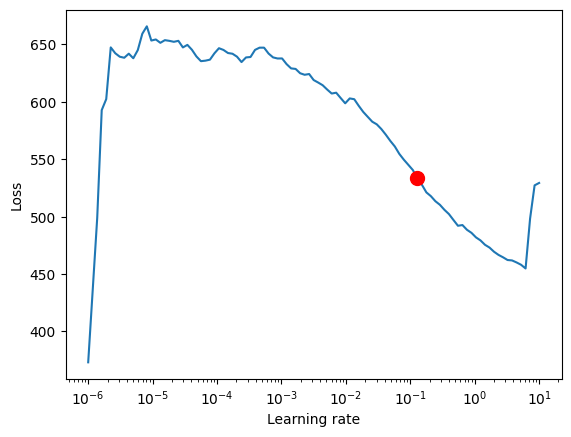

C:\Users\lvdburchard\AppData\Local\Temp\ipykernel_8980\2987656451.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [51]:
# Optional: Determine learning rate
if False:
    # configure network and trainer
    pl.seed_everything(42)
    trainer = pl.Trainer(
        accelerator="cpu",
        # clipping gradients is a hyperparameter and important to prevent divergance
        # of the gradient for recurrent neural networks
        gradient_clip_val=0.1,
    )


    tft = TemporalFusionTransformer.from_dataset(
        training,
        # not meaningful for finding the learning rate but otherwise very important
        learning_rate=0.03,
        hidden_size=8,  # most important hyperparameter apart from learning rate
        # number of attention heads. Set to up to 4 for large datasets
        attention_head_size=4,
        dropout=0.1,  # between 0.1 and 0.3 are good values
        hidden_continuous_size=8,  # set to <= hidden_size
        loss=QuantileLoss(),
        optimizer="Ranger"
        # reduce learning rate if no improvement in validation loss after x epochs
        # reduce_on_plateau_patience=1000,
    )
    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    res = Tuner(trainer).lr_find(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
        max_lr=10.0,
        min_lr=1e-6,
    )

    print(f"suggested learning rate: {res.suggestion()}")
    fig = res.plot(show=True, suggest=True)
    fig.show()


In [73]:

# configure network and trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
# logging results to a tensorboard
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.08,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")



Number of parameters in network: 28.2k


c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [74]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 536   
3  | prescalers                         | ModuleDict                      | 128   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 5.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 42: 100%|██████████| 50/50 [00:09<00:00,  5.08it/s, v_num=7, train_loss_step=222.0, val_loss=327.0, train_loss_epoch=220.0]


In [109]:

# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True, return_index=True, return_y=True)

def raw_preds_to_df(raw,idx_offset,quantiles = None):
    """
    raw is output of model.predict with return_index=True
    quantiles can be provided like [0.1,0.5,0.9] to get interpretable quantiles
    in the output, time_idx is the first prediction time index (one step after knowledge cutoff)
    pred_idx the index of the predicted date i.e. time_idx + h - 1
    """
    index = raw.index
    preds = raw.output.prediction
    dec_len = raw.output.prediction.shape[1]
    n_quantiles = preds.shape[-1]
    preds_df = pd.DataFrame(index.values.repeat(dec_len * n_quantiles, axis=0),columns=index.columns)
    preds_df = preds_df.assign(Horizon=np.tile(np.repeat(np.arange(1,1+dec_len),n_quantiles),len(preds_df)//(dec_len*n_quantiles)))
    preds_df = preds_df.assign(Quantile=np.tile(np.arange(n_quantiles),len(preds_df)//n_quantiles))
    preds_df = preds_df.assign(Prediction=preds.flatten().cpu().numpy())
    if quantiles is not None:
        preds_df['Quantile'] = preds_df['Quantile'].map({i:q for i,q in enumerate(quantiles)})

    preds_df['pred_idx'] = preds_df['time_idx'] + preds_df['Horizon'] - 1
    preds_df['TargetDate'] = pd.to_datetime(idx_offset)
    preds_df['TargetDate'] = preds_df['TargetDate'] + preds_df['pred_idx'].apply(pd.DateOffset)
    return preds_df

pred = raw_preds_to_df(raw_predictions, first_date)
# default quantiles are  [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
# therefore, Quantile=3 is median
print(pred[(pred["Branch"] == "1") & (pred["Group"] == "1") & (pred["Quantile"] == 3)])

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


   time_idx Branch Group  Horizon  Quantile   Prediction pred_idx  \
3      2731      1     1        1         3  2256.200928     2731   
10     2731      1     1        2         3  2344.048828     2732   
17     2731      1     1        3         3  2169.358643     2733   

             TargetDate  
3   2023-06-24 00:00:00  
10  2023-06-25 00:00:00  
17  2023-06-26 00:00:00  


c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\lvdburchard\AppData\Local\Temp\ipykernel_8980\2709410912.py:27: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  preds_df['TargetDate'] = preds_df['TargetDate'] + preds_df['pred_idx'].apply(pd.DateOffset)
